# Test workflow for taking old, segmentation files from Matlab and reproducing the Delta processing to prepare them for training U net

This is what needs to happen: 

## Initial scan
* Scan directories for file names
* Sort lists of names so that brightfield movies correspond with matlab files... maybe just do this manually
* Scan all brightfield files to look at distributions of image sizes... decide on cropping scheme for further analysis

## Iterate through all movies saving cropped brightfield and segmented movies
* load in movie
* move onto next movie if dimensions are too small to match crop target, otherwise...
    * load segmented movie and manipulate to thicken objects while preserving border
    * crop to taret crop size... in our case the colonies are more or less centered always
    * increment class0 and class1 sums from background/cell pixel counts
    * save with individual filenames to match Delta requirements... 
    
## Iterate through all movies to generate and save 

In [2]:
# Load needed modules and define functions used later
%load_ext autoreload
%autoreload 2

from matlabProcTools import *
from IPython.display import clear_output

In [3]:
# read in file names... can automate this but manually for now... check sizes of all images to choose images to use

fileInxs1 = ['1','2','3','4','5','6','7','8','9','10','11','13','14','15']
fileInxs2 = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15']

matFiles = []
bfFiles = []

for i in fileInxs1:
    matFiles.append('x222 data/141007_x222_'+i+'.mat')
    bfFiles.append('x222 data/first day/bf'+i+'_cropped.tif')

for i in fileInxs2:
    matFiles.append('x222 data/141030_x222_'+i+'.mat')
    bfFiles.append('x222 data/second day/bf'+i+'_cropped.tif')
    
# open all files and get sizes of first frame

sY = np.zeros(len(bfFiles))
sX = np.zeros(len(bfFiles))

useMovies = np.zeros(len(bfFiles))

for i in range(len(bfFiles)):
    path = bfFiles[i]
    bf_img = io.imread(path)[0,:,:]

    # calculate cropping
    sY[i] = 2**math.floor(math.log2(bf_img.shape[0]))
    sX[i] = 2**math.floor(math.log2(bf_img.shape[1]))
    
    if sY[i]>128 and sX[i]>64:
        useMovies[i] = 1
        

print(sY)
print(sX)
print(useMovies)
# based on this from test data... can crop to 128x128 and use 28 of 29 movies or crop to 128x256 (X x Y) and use 11 of 29 movies... try the latter first

[256. 128. 128. 256. 128. 256. 256. 128. 256. 256. 128. 128. 256. 128.
 256. 128. 128. 256. 128. 128. 128. 256. 128. 128. 128. 128. 256. 128.
 128.]
[128.  64. 128. 128. 128. 128. 256. 128. 128. 128. 128. 128. 128. 128.
 128. 128. 128. 128. 128. 128. 128. 256. 128. 128. 128. 128. 256. 128.
 128.]
[1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0.
 0. 0. 1. 0. 0.]


In [4]:
trainDir = 'train'
ensure_dir(trainDir)
ensure_dir(trainDir+'/img')
ensure_dir(trainDir+'/seg')
ensure_dir(trainDir+'/wei')

# some parameters
cropY = 256
cropX = 128

erode_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))

sampleIdx = 1

class0 = float(0)
class1 = float(0)


#class0 = float(np.sum(seg==0))
#class1 = float(np.sum(seg==1))


for i in np.nonzero(useMovies)[0]:
    path = bfFiles[i]
    bf_img = io.imread(path)

    path = matFiles[i]
    matFile = sio.loadmat(path,variable_names=['firstFrame','lastFrame','r'])
    
    for j in range(matFile['firstFrame'][0,0]-1, matFile['lastFrame'][0,0]):
        
        clear_output(wait = True)
        print(sampleIdx)
        
        # crop brightfield image
        bfSize = bf_img[j].shape
        img = crop_center(bf_img[j],cropX,cropY)
        
        # rescale, convert to 8 bit, and save bf image
        img = img - img.min()
        img = img.astype('float32')
        img = 255*img/img.max()
        img = np.rint(img)
        img = img.astype('uint8')
        img = Image.fromarray(img)
        img.save(trainDir + '/img/sample_' + str(sampleIdx).zfill(6) + '.png')
        
        img = matFile['r']['seg'][0,j]>0
        img = img.astype(np.uint8)
        img = bwthicken(img,4)
        img = cv2.erode(img,erode_kernel,iterations = 1)
        img = Image.fromarray(img)
        img = img.resize(bfSize[::-1])
        img = np.array(img)
        img = crop_center(img,cropX,cropY)
        class0 += np.sum(img==0)
        class1 += np.sum(img==1)
        img = 255*img
        img = Image.fromarray(img)
        img.save(trainDir + '/seg/sample_' + str(sampleIdx).zfill(6) + '.png')
        
        sampleIdx += 1

1274


In [5]:
# Calculate and save weight images
sampleIdx
sigma = 2 # higher = less steep weights at cell-cell contacts
w0 = 20 # higher = more priority to cell-cell contacts
rescale = 18 # try to use whole 0-255 range for weight images
eraseContour = 1

if class0 > class1:
    weight_c0 = 1
    weight_c1 = class0/class1
else:
    weight_c0 = class1/class0
    weight_c1 = 1
 
for i in range(sampleIdx-1):
    
    clear_output(wait = True)
    print(float(i)/(sampleIdx-2))
    
    img = io.imread(trainDir + '/seg/sample_' + str(i+1).zfill(6) + '.png')
    img = weightmap(img,weight_c0,weight_c1,sigma,w0,rescale,eraseContour)
    img = Image.fromarray(img)
    img.save(trainDir + '/wei/sample_' + str(i+1).zfill(6) + '.png')


1.0


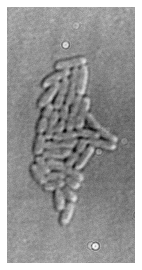

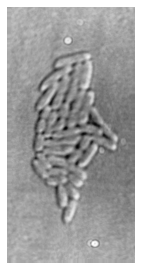

In [6]:
# test elastic deformation
trainDir = 'train'
import elasticdeform
img = io.imread(trainDir + '/img/sample_' + str(100).zfill(6) + '.png')
display_image_in_actual_size(img,cm='Greys')
test = elasticdeform.deform_random_grid(img,
                                      sigma=4,
                                      points=4,
                                      mode='nearest',
                                      axis=(0,1),
                                      prefilter=False)
display_image_in_actual_size(test,cm='Greys')

In [ ]:
# Train UNet on all data

from model import unet_seg
from data import trainGenerator_seg
from tensorflow.keras.callbacks import ModelCheckpoint

# Files:
DeLTA_data = 'C:/Users/User/Desktop/ZHX222 segmentation/'
training_set = 'train/'
old_model_file = DeLTA_data + 'models/unet_moma_seg.hdf5'
model_file = DeLTA_data + 'models/unet_moma_seg.hdf5'

# Parameters:
target_size = (256, 128)
input_size = target_size + (1,)
batch_size = 8
epochs = 200
steps_per_epoch = 250

#Data generator:

ed_params = dict(sigma=3,points=3)

data_gen_args = dict(
                    rotation = 0.5,
                    shiftX=.05,
                    shiftY=.05,
                    zoom=.15,
                    horizontal_flip=True,
                    histogram_voodoo=True,
                    illumination_voodoo=True)

# data_gen_args = dict(
#                     rotation = 0.5,
#                     shiftX=.05,
#                     shiftY=.05,
#                     zoom=.15,
#                     horizontal_flip=True,
#                     histogram_voodoo=True,
#                     illumination_voodoo=True,
#                     elastic_deformation=ed_params)

# data_gen_args = dict(
#                     horizontal_flip=True,
#                     vertical_flip=True,
#                     histogram_voodoo=True,
#                     illumination_voodoo=True)

myGene = trainGenerator_seg(batch_size,
                           training_set + 'img/',
                           training_set + 'seg/',
                           training_set + 'wei/',
                           augment_params = data_gen_args,
                           target_size = target_size)

# Define model:
model = unet_seg(input_size = input_size)
model.summary()
model.load_weights(old_model_file) # load in previous weights if wanted

# model_checkpoint = ModelCheckpoint(model_file, monitor='loss',verbose=1, save_best_only=True) # changed to keep all new models bc data is always a bit different
model_checkpoint = ModelCheckpoint(model_file, monitor='loss',verbose=1, save_best_only=False)

# Train it:
model.fit_generator(myGene,steps_per_epoch=steps_per_epoch,epochs=epochs,callbacks=[model_checkpoint])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
true_input (InputLayer)         (None, 256, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 128, 64) 640         true_input[0][0]                 
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 128, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPoo

In [2]:
# segment newer data resized to 256 x 256 
from matlabProcTools import *
from data import saveResult_seg, predictGenerator_seg, postprocess
from model import unet_seg
from os import listdir

# Files:
DeLTA_data = 'C:/Users/User/Desktop/ZHX222 segmentation/'
inputs_folder = DeLTA_data + 'evalNew/img/'

ensure_dir(DeLTA_data + 'evalNew/seg_noCrop_delta/')
outputs_folder = DeLTA_data + 'evalNew/seg_noCrop_delta/'
model_file = DeLTA_data + 'models/unet_moma_seg.hdf5'
unprocessed = listdir(inputs_folder)

# Parameters:
target_size = (256, 256)
input_size = target_size + (1,)
process_size = 4096

# Load up model:
model = unet_seg(input_size = input_size)
model.load_weights(model_file)

# Process
while(unprocessed):
    # Pop out filenames
    ps = min(process_size,len(unprocessed))
    to_process = unprocessed[0:ps]
    del unprocessed[0:ps]
    
    # Predict:
    predGene = predictGenerator_seg(inputs_folder, files_list = to_process, target_size = target_size)
    results = model.predict_generator(predGene,len(to_process),verbose=1)
    
    # Post process results:
    results[:,:,:,0] = postprocess(results[:,:,:,0])
    
    # Save to disk:
    saveResult_seg(outputs_folder,results, files_list = to_process)

66/66 [==============================] - 6s 87ms/step


In [3]:
# segment newer data cropped to 128 128
from matlabProcTools import *
from data import saveResult_seg, predictGenerator_seg, postprocess
from model import unet_seg
from os import listdir

# Files:
DeLTA_data = 'C:/Users/User/Desktop/ZHX222 segmentation/'
inputs_folder = DeLTA_data + 'evalNew/imgCropped/'

ensure_dir(DeLTA_data + 'evalNew/seg_delta/')
outputs_folder = DeLTA_data + 'evalNew/seg_delta/'
model_file = DeLTA_data + 'models/unet_moma_seg.hdf5'
unprocessed = listdir(inputs_folder)

# Parameters:
target_size = (128, 128)
input_size = target_size + (1,)
process_size = 4096

# Load up model:
model = unet_seg(input_size = input_size)
model.load_weights(model_file)

# Process
while(unprocessed):
    # Pop out filenames
    ps = min(process_size,len(unprocessed))
    to_process = unprocessed[0:ps]
    del unprocessed[0:ps]
    
    # Predict:
    predGene = predictGenerator_seg(inputs_folder, files_list = to_process, target_size = target_size)
    results = model.predict_generator(predGene,len(to_process),verbose=1)
    
    # Post process results:
    results[:,:,:,0] = postprocess(results[:,:,:,0])
    
    # Save to disk:
    saveResult_seg(outputs_folder,results, files_list = to_process)

66/66 [==============================] - 3s 43ms/step


In [4]:
# segment remaining data (moved images 1001 - x) using model trained on other data
from matlabProcTools import *
from data import saveResult_seg, predictGenerator_seg, postprocess
from model import unet_seg
from os import listdir

# Files:
DeLTA_data = 'C:/Users/User/Desktop/ZHX222 segmentation/'
inputs_folder = DeLTA_data + 'evalOld/img/'

ensure_dir(DeLTA_data + 'evalOld/seg_delta/')
outputs_folder = DeLTA_data + 'evalOld/seg_delta/'
model_file = DeLTA_data + 'models/unet_moma_seg.hdf5'
unprocessed = listdir(inputs_folder)

# Parameters:
target_size = (256, 128)
input_size = target_size + (1,)
process_size = 4096

# Load up model:
model = unet_seg(input_size = input_size)
model.load_weights(model_file)

# Process
while(unprocessed):
    # Pop out filenames
    ps = min(process_size,len(unprocessed))
    to_process = unprocessed[0:ps]
    del unprocessed[0:ps]
    
    # Predict:
    predGene = predictGenerator_seg(inputs_folder, files_list = to_process, target_size = target_size)
    results = model.predict_generator(predGene,len(to_process),verbose=1)
    
    # Post process results:
    results[:,:,:,0] = postprocess(results[:,:,:,0])
    
    # Save to disk:
    saveResult_seg(outputs_folder,results, files_list = to_process)


274/274 [==============================] - 13s 46ms/step
